In [1]:
from gaussian_kde.gaussian_kde import gaussian_kde
from scipy.stats import multivariate_normal
import scipy
import numpy as np

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter, NullLocator, MultipleLocator

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Gaussian KDE Conditional Distributions

First, let's generate a non-trivial test distribution.

In [126]:
# I am borrowing this from AstroML
# http://www.astroml.org/book_figures/chapter3/fig_conditional_probability.html

def banana_distribution(N=10000):
    """
    This generates random points in a banana shape
    """
    # create a truncated normal distribution
    theta = np.random.normal(0, np.pi / 8, 10000)
    theta[theta >= np.pi / 4] /= 2
    theta[theta <= -np.pi / 4] /= 2
    
    # define the curve parametrically
    r = np.sqrt(1. / abs(np.cos(theta) ** 2 - np.sin(theta) ** 2))
    r += np.random.normal(0, 0.08, size=10000)
    x = r * np.cos(theta + np.pi / 4)
    y = r * np.sin(theta + np.pi / 4)
    
    return (x, y)

In [127]:
# randomly sample from this distribution

np.random.seed(1)
x, y = banana_distribution(10000)

In [142]:
# apply gaissian KDE

values = np.vstack([x,y]).T
kernel = gaussian_kde(values.T, bw_method=0.06)

In [143]:
# resample from the full 2D distribution using the KDE estimate

result = kernel.resample(size=10000)
x_new,y_new = result[0,:],result[1,:]

In [144]:
# sample from conditional distribution
# at three different values of y

y_c = np.array([1.46341463,0.97560976,0.48780488])

samples_1 = kernel.conditional_sample(np.ones(10000)*y_c[0], c=[False, True])
samples_2 = kernel.conditional_sample(np.ones(10000)*y_c[1], c=[False, True])
samples_3 = kernel.conditional_sample(np.ones(10000)*y_c[2], c=[False, True])

In [145]:
# calculate the 2D density in bins

X, Y = np.mgrid[0:2:100j, 0:2:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

Ngrid = 41
grid = np.linspace(0, 2, Ngrid + 1)

H, xbins, ybins = np.histogram2d(x, y, grid)
H /= np.sum(H)

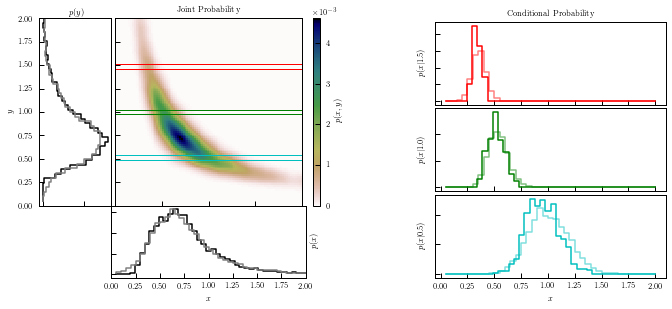

In [146]:
# plot the results
xmin, xmax = (0,2)
ymin, ymax = (0,2)

fig = plt.figure(figsize=(10, 5))

# define axes
ax_Pxy = plt.axes((0.2, 0.34, 0.27, 0.52))
ax_Px = plt.axes((0.2, 0.14, 0.27, 0.2))
ax_Py = plt.axes((0.1, 0.34, 0.1, 0.52))
ax_cb = plt.axes((0.48, 0.34, 0.01, 0.52))
ax_Px_y = [plt.axes((0.65, 0.62, 0.32, 0.23)),
           plt.axes((0.65, 0.38, 0.32, 0.23)),
           plt.axes((0.65, 0.14, 0.32, 0.23))]

# set axis label formatters
ax_Px_y[0].xaxis.set_major_formatter(NullFormatter())
ax_Px_y[1].xaxis.set_major_formatter(NullFormatter())

ax_Pxy.xaxis.set_major_formatter(NullFormatter())
ax_Pxy.yaxis.set_major_formatter(NullFormatter())

ax_Px.yaxis.set_major_formatter(NullFormatter())
ax_Py.xaxis.set_major_formatter(NullFormatter())

# draw the joint probability
plt.axes(ax_Pxy)
#H *= 1000
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
#plt.plot(x, y, 'k.', markersize=1, alpha=0.2)
cb = plt.colorbar(cax=ax_cb)
cb.set_label('$p(x, y)$')
plt.text(0, 1.02, r'$\times 10^{-3}$',
         transform=ax_cb.transAxes)

# draw p(x) distribution
ax_Px.plot(xbins[1:], 1.0*H.sum(0)/np.diff(xbins), '-k', drawstyle='steps')

# draw p(y) distribution
ax_Py.plot(1.0*H.sum(1)/np.diff(ybins), ybins[1:], '-k', drawstyle='steps')

# define axis limits
ax_Pxy.set_xlim(0, 2)
ax_Pxy.set_ylim(0, 2)
ax_Px.set_xlim(0, 2)
ax_Py.set_ylim(0, 2)

# label axes
ax_Pxy.set_xlabel('$x$')
ax_Pxy.set_ylabel('$y$')
ax_Px.set_xlabel('$x$')
ax_Px.set_ylabel('$p(x)$')
ax_Px.yaxis.set_label_position('right')
ax_Py.set_ylabel('$y$')
ax_Py.set_xlabel('$p(y)$')
ax_Py.xaxis.set_label_position('top')

# draw marginal probabilities
iy = [3 * Ngrid / 4, Ngrid / 2, Ngrid / 4]
colors = 'rgc'
axis = ax_Pxy.axis()
for i in range(3):
    # overplot range on joint probability
    ax_Pxy.plot([0, 2, 2, 0],
                [ybins[iy[i] + 1], ybins[iy[i] + 1],
                 ybins[iy[i]], ybins[iy[i]]], c=colors[i], lw=1)
    Px_y = H[iy[i]] / H[iy[i]].sum()/np.diff(xbins)
    ax_Px_y[i].plot(xbins[1:], Px_y, drawstyle='steps', c=colors[i])
    ax_Px_y[i].yaxis.set_major_formatter(NullFormatter())
    ax_Px_y[i].set_ylabel('$p(x | %.1f)$' % ybins[iy[i]])
ax_Pxy.axis(axis)

ax_Px_y[2].set_xlabel('$x$')

ax_Pxy.set_title('Joint Probability')
ax_Px_y[0].set_title('Conditional Probability')

# conditional distributions
bins = np.linspace(0,2,41)
counts = np.histogram(samples_1, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)
ax_Px_y[0].step(bins[1:], counts, color=colors[0], alpha=0.5)

counts = np.histogram(samples_2, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)
ax_Px_y[1].step(bins[1:], counts, color=colors[1], alpha=0.5)

counts = np.histogram(samples_3, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)
ax_Px_y[2].step(bins[1:], counts, color=colors[2], alpha=0.5)

# marginalized distributions
bins = np.linspace(0,2,41)
counts = np.histogram(x_new, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)
ax_Px.step(bins[1:], counts, '-', color='grey')

counts = np.histogram(y_new, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)
ax_Py.step(counts, bins[1:], '-', color='grey')

plt.show()

The 2D KDE result is shown as the color-coded scale.  

The solid black lines and darker colored lines are the histograms binning the data directly sampled from the banana distribution

The grey and lighter colored l